# Step 1: Import Packages & Spotify Authentication

In [1]:
import sys
import spotipy
import spotipy.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

scope = 'user-library-read'
token = util.prompt_for_user_token("11100316938",scope,client_id='bddfdc9233b5493899809dcc42ca5cc3',client_secret='d97a1e581b5f4b4b9da348d6a0529e02',redirect_uri='http://localhost:5000/callback')
spotify = spotipy.Spotify(auth = token)

# Functions

## getPlaylistFeatures()
 returns an array with DataFrame of Tracks and Name of playlist in the following tuple
- (playlistDF, playlistName)

In [2]:
def getPlaylistFeatures(playlistURI, playlistNum):
    
    userPlaylistResponse = spotify.user_playlist("11100316938", playlistURI)
    playlistName = userPlaylistResponse["name"]
    
    #tracks are returned in this JSON response
    tracksResponse = spotify.user_playlist_tracks("11100316938", playlistURI)
    tracks = tracksResponse["items"]
    
    #instantiate an empty array and place the Tracks URI in this array
    tracksArray = [] 
    for track in tracks:
        URI = track["track"]["id"]
        tracksArray.append(URI)
    
    dfArray = [] #empty array the DataFrame will intake
    dfColumns = ["trackURI", "danceability", "energy", "acousticness", "tempo", "valence", "loudness", "speechiness", "instrumentalness", "playlistNum"] #columns that make DataFrame
        
    #code to iterate through each track URI and get its respective features
    #slice 10
    for trackURI in tracksArray:
        trackFeatures = spotify.audio_features(trackURI)
        
        danceability = trackFeatures[0]["danceability"]
        energy = trackFeatures[0]["energy"]
        acousticness = trackFeatures[0]["acousticness"]
        tempo = trackFeatures[0]["tempo"]
        valence = trackFeatures[0]["valence"]
        loudness = trackFeatures[0]["loudness"]
        speechiness = trackFeatures[0]["speechiness"]
        instrumentalness = trackFeatures[0]["instrumentalness"]
        
        tempArray = [trackURI, danceability, energy, acousticness, tempo, valence, loudness, speechiness, instrumentalness, playlistNum]
        dfArray.append(tempArray)
        
    playlistDF = pd.DataFrame(dfArray, columns = dfColumns)
    return (playlistDF, playlistName)


# mostDissimilarFeatures(playlist1,playlist2)
- returns a dataframe with the most dissimilar features in descending order
- the dissimilarity is computed with Euclidean Distance between the means of each features respective to their playlist

In [3]:
def mostDissimilarFeatures(playlist1DF, playlist2DF):
#     playlist1 = getPlaylistFeatures(playlist1, 1)
#     playlist2 = getPlaylistFeatures(playlist2, 2)
    
    playlist1Mean = pd.DataFrame(playlist1DF[["danceability", "energy", "acousticness", "valence", "instrumentalness", "speechiness"]].mean(), columns = ["playlist1"])
    playlist2Mean = pd.DataFrame(playlist2DF[["danceability", "energy", "acousticness", "valence", "instrumentalness", "speechiness"]].mean(), columns = ["playlist2"])

    mergedMeans = playlist1Mean.join(playlist2Mean)
    
    differenced = mergedMeans.assign(absoluteDifference = lambda x: np.absolute(mergedMeans["playlist1"] - mergedMeans["playlist2"]))
    differenced = differenced.sort_values("absoluteDifference", ascending = False)

    display(differenced)
    playlist1Mean.plot(kind='bar')
    playlist2Mean.plot(kind='bar')

    topDissimilar = differenced.index
    
    return topDissimilar

# plotPlaylists(playlist1, playlist2)
- plots the top two dissimilar features amongsts the two playlist to help us visualize how different or similar they are

In [4]:
def plotPlaylists(playlist1, playlist2, feature1, feature2):
#     feature1 = "acousticness"
#     feature2 = "instrumentalness"

    playlist1DF = playlist1[0]
    playlist2DF = playlist2[0]
    
    playlist1Name = playlist1[1]
    playlist2Name = playlist2[1]

    plt.scatter(playlist1DF[feature1], playlist1DF[feature2], c = "r")
    plt.scatter(playlist2DF[feature1], playlist2DF[feature2], c = "g")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(labels = [playlist1Name, playlist2Name])
    plt.show

# KNNPredict(songURI, kNeighbors)
- this function will take a user input a song and tell you which playlist the song best belongs to using K-Nearest Neighbors Algorithm that is built into SciKit Learn
- Model is fitted from a dataFrame that contains the following:
    - Input: [feature1, feature2]
    - Output: Classification ... or which playlist those features belong to

In [5]:
def KNNPredict(kNeighbors, playlist1, playlist2, feature1, feature2, songFeatures):

    merge = [playlist1[0],playlist2[0]] 
    dfMerge = pd.concat(merge)

    features = dfMerge[[feature1,feature2]]
    classification = dfMerge['playlistNum']
    
    model = KNeighborsClassifier(n_neighbors=kNeighbors)
    model.fit(features, classification)
    
#     return(model)
    return(model.predict([songFeatures]))

# getSongFeatures(songURI)
- gets the features from the song to analyze and then eventually predict.
- returns a DataFrame of song features

In [6]:
def getSongFeature(songURI):
    features = spotify.audio_features(songURI)
    features = features[0]
    
    display(features)
    
    danceability = features["danceability"]
    energy = features["energy"]
    acousticness = features["acousticness"]
    tempo = features["tempo"]
    valence = features["valence"]
    loudness = features["loudness"]
    speechiness = features["speechiness"]
    instrumentalness = features["instrumentalness"]
    
    dfArray = [danceability, energy, acousticness, tempo, valence, loudness, speechiness, instrumentalness] #empty array the DataFrame will intake
    dfColumns = ["danceability", "energy", "acousticness", "tempo", "valence", "loudness", "speechiness", "instrumentalness"] #columns that make DataFrame
    
    trackFeatures = pd.DataFrame(dfArray, index = dfColumns)
    trackFeatures = trackFeatures.transpose()
    return(trackFeatures)

# getSongName(songURI)

In [7]:
def getSongName(songURI):
    trackName = (spotify.track(songURI)["name"])
    return(trackName)

# Step 2: Input Playlist to Analyze
- Using two Spotify featured playlists' playlistID's

In [8]:
playlist1Input = '296W1tgCGPvAjyCSSdiUsG' #slow rock
playlist2Input = '37i9dQZF1DXcZDD7cfEKhW' #dance pop

# Step 3: Retrieve Playlists Information
- Call the function to retrieve the tracks from each playlists and their features
- We also get the playlist's name

In [9]:
playlist1 = getPlaylistFeatures(playlist1Input, 1)
playlist2 = getPlaylistFeatures(playlist2Input, 2)

#the variables above contain both a DataFrame and the name. We access them by parsing through the returned tuple
playlist1DF = playlist1[0]
playlist1Name = playlist1[1]

playlist2DF = playlist2[0]
playlist2Name = playlist2[1]

In [10]:
display(playlist1Name)
display(playlist1DF.head())

display(playlist2Name)
display(playlist2DF.head())

'Slow Rock (Greatest Hits)'

,trackURI,danceability,energy,acousticness,tempo,valence,loudness,speechiness,instrumentalness,playlistNum
0,4YJ4n7DsZhR5hrnsMfn6zV,0.446,0.409,0.287,151.457,0.295,-14.817,0.0368,0.000000,1
1,4U6eiIdgTZlksnUKZbNPrX,0.600,0.766,0.344,114.422,0.352,-7.191,0.3240,0.000022,1
2,6Z435tBPT5JamUR9dN7y8y,0.486,0.487,0.445,81.972,0.373,-11.633,0.0341,0.000014,1
3,2yX3h3NRoMWGfnXxZlF92X,0.334,0.188,0.932,77.960,0.223,-11.461,0.0289,0.000002,1
4,5CQ30WqJwcep0pYcV4AMNc,0.338,0.340,0.580,82.433,0.197,-12.049,0.0339,0.003200,1


'Dance Pop'

,trackURI,danceability,energy,acousticness,tempo,valence,loudness,speechiness,instrumentalness,playlistNum
0,6e0CvGZf7CouOpYF8toXHC,0.744,0.726,0.03990,121.985,0.687,-4.675,0.0463,0.000000,2
1,43IWqSUbgHujwQ6YFGVPth,0.698,0.792,0.02960,125.976,0.333,-3.583,0.0418,0.000039,2
2,7Feaw9WAEREY0DUOSXJLOM,0.726,0.722,0.17300,113.920,0.345,-7.007,0.0456,0.000010,2
3,0ywzvARVqoxQOJpaswRe9E,0.784,0.595,0.00476,124.019,0.183,-6.816,0.0413,0.007270,2
4,1hr5Y2i4NlE3LPvQZ9Q5Ao,0.679,0.909,0.03340,119.885,0.819,-2.929,0.1050,0.000000,2


# Step 3: Identify Most Dissimilar Features

,playlist1,playlist2,absoluteDifference
energy,0.506747,0.804937,0.298190
acousticness,0.270463,0.089748,0.180715
danceability,0.510241,0.667375,0.157134
valence,0.403375,0.451875,0.048500
speechiness,0.051887,0.090294,0.038406
instrumentalness,0.024486,0.021365,0.003121


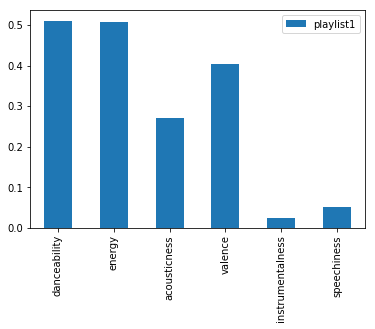

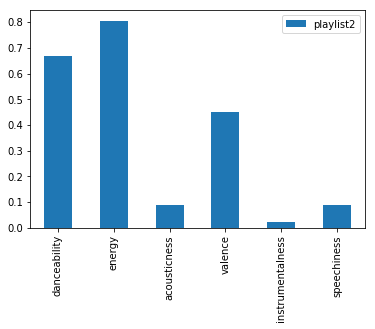

In [11]:
# we input the DataFrames for each playlist into the function
mostDissimilar = mostDissimilarFeatures(playlist1DF, playlist2DF)

# we only want the top 2 dissimilar features
top2Dissimilar = mostDissimilar.values.tolist() #conver to list to access
feature1 = top2Dissimilar[0]
feature2 = top2Dissimilar[1]

# Step 4: Plot Dissimilar Features

In [12]:
# feature1 = input("Feature #1 to analyze: ")
# feature2 = input("Feature #2 to analyze: ")

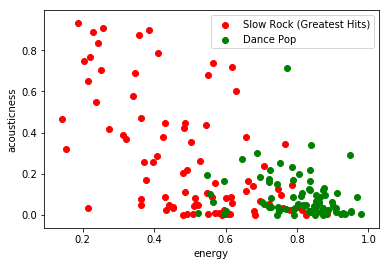

In [13]:
plotPlaylists(playlist1, playlist2, feature1, feature2)

# Step 5: Get Song Features
- get the features of the song that we want to see where it belongs

In [14]:
from sklearn.neighbors import KNeighborsClassifier
song = '4YJ4n7DsZhR5hrnsMfn6zV'

trackFeatures = getSongFeature(song)
trackName = getSongName(song)
trackFeature1 = trackFeatures.loc[0, feature1]
trackFeature2 = trackFeatures.loc[0, feature2]
#this array contains the values of our top two dissimilar features
trackFeatureValues = [trackFeature1, trackFeature2] 

{'danceability': 0.446,
 'energy': 0.409,
 'key': 0,
 'loudness': -14.817,
 'mode': 1,
 'speechiness': 0.0368,
 'acousticness': 0.287,
 'instrumentalness': 0,
 'liveness': 0.0788,
 'valence': 0.295,
 'tempo': 151.457,
 'type': 'audio_features',
 'id': '4YJ4n7DsZhR5hrnsMfn6zV',
 'uri': 'spotify:track:4YJ4n7DsZhR5hrnsMfn6zV',
 'track_href': 'https://api.spotify.com/v1/tracks/4YJ4n7DsZhR5hrnsMfn6zV',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4YJ4n7DsZhR5hrnsMfn6zV',
 'duration_ms': 313693,
 'time_signature': 4}

# Step 6: Make the actual prediction using KNN
- make the prediction using K-Nearest Neighbors Algorithm and store that model into a variable *myModel*
- then proceed to output the prediciton

In [15]:
myModel = KNNPredict(25, playlist1, playlist2, feature1, feature2, trackFeatureValues)

In [16]:
if(myModel[0] == 1 ):
    print(trackName + "' best belongs in '" + playlist1Name + "' playlist")
else:
    print(trackName + "' best belongs in '" + playlist2Name + "' playlist")

Wind Of Change' best belongs in 'Slow Rock (Greatest Hits)' playlist


## Plotting

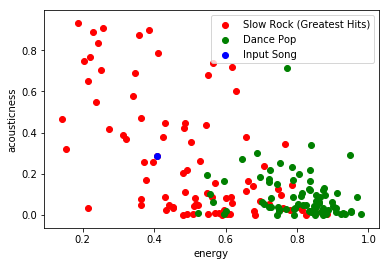

In [17]:
myPlot = plotPlaylists(playlist1, playlist2, feature1, feature2)
trackFeatureValues
plt.scatter(trackFeatureValues[0], trackFeatureValues[1], c = "b")
plt.legend([playlist1Name, playlist2Name,"Input Song"])

# Step 7: Homemade prediction
- Calculate the difference of 3 most dissimilar features of playlist1 and playlist2 with the input song's 3 most dissimilar features

In [18]:
differenceFromPlaylist1 = [0,0,0]
differenceSum = 0
for x in range(0, 3):
    differenceFromPlaylist1[x] = abs(playlist1DF[top2Dissimilar[x]].mean() - trackFeatures[top2Dissimilar[x]].values)
    differenceSum += differenceFromPlaylist1[x]
print(differenceFromPlaylist1)
print(differenceSum)

[array([0.09774713]), array([0.01653701]), array([0.06424138])]
[0.17852552]


In [19]:
differenceFromPlaylist2 = [0,0,0]
differenceSum2 = 0
for x in range(0, 3):
    differenceFromPlaylist2[x] = abs(playlist2DF[top2Dissimilar[x]].mean() - trackFeatures[top2Dissimilar[x]].values)
    differenceSum2 += differenceFromPlaylist2[x]
print(differenceFromPlaylist2)
print(differenceSum2)

[array([0.3959375]), array([0.19725205]), array([0.221375])]
[0.81456455]


In [20]:
SimilarityToPlaylist1 = ((3-differenceSum)*100)/3
print('Similarity to playlist 1: ' + str(SimilarityToPlaylist1[0]) + '%')

Similarity to playlist 1: 94.04914942528734%


In [21]:
SimilarityToPlaylist2 = ((3-differenceSum2)*100)/3
print('Similarity to playlist 2: ' + str(SimilarityToPlaylist2[0]) + '%')

Similarity to playlist 2: 72.84784833333333%
